## Import libraries. 

In [1]:
# External libraries. 
import  numpy;
import  matplotlib.pyplot   as plt;
import  matplotlib          as mpl;
import  seaborn;
import  torch;
from    scipy               import  interpolate;

# Python libraries. 
from    typing              import  List, Dict, Tuple;

## Import my code

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

Here, we implement the loss functions that we try to minimize. 

In [2]:
from    Model   import  Logistic_Model      as Model;
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE_1D;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL;

# logger setup.
import  logging;

Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# plot setup. 
Initialize_MPL();

# Select l, g.
def l(x : torch.Tensor, y : torch.Tensor) -> torch.Tensor:
    """
    This function computes the L2 norm squared between x and y. Thus, if x, y \in R^d, then we 
    return 
            (x_0 - y_0)^2 + ... + (x_{d - 1} - y_{d - 1})^2

    -----------------------------------------------------------------------------------------------
    Arguments:

    x, y: 1D tensors. They must have the same number of components.
    """

    # Run checks.
    assert(len(x.shape) == 1);
    assert(x.shape      == y.shape);

    # Compute the L2 norm squared between x and y, return it.
    return torch.sum(torch.square(x - y));



def G(xT_Predict    : torch.Tensor, xT_Target) -> torch.Tensor:
    """ 
    Implements the "G" portion of the loss function for the NDDE algorithm.
    """

    return torch.sum(torch.square(xT_Predict - xT_Target));


### Generate Target Trajectory

Generate the target trajectory and plot it!

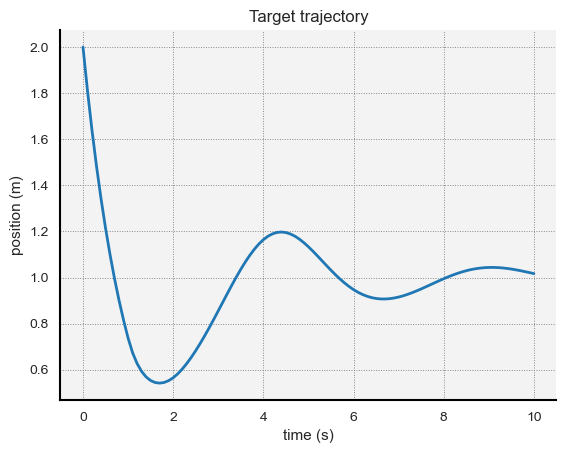

In [3]:
# Set up the parameters and tau value for the target trajectory.
F_Target        = Model(theta_0 = 1.0, theta_1 = 1.0);
x_0_Target      = torch.tensor([2.0]);
tau_Target      = torch.tensor(1.0);
T_Target        = torch.tensor(10.0);

# Get the target trajectory!
x_Target, t_Target  = DDE_Solver(F = F_Target, x_0 = x_0_Target, tau = tau_Target, T = T_Target);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_Target.reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("Target trajectory");

### Setup, train the Model 


In [4]:
# Settings for training
N_Epochs        : int       = 1000;
Learning_Rate   : float     = 0.1;

Loss_Threshold  : float     = 0.001;             # Will exit when loss drops below this.

  10:   Loss = 28.91466  | tau = 1.05185  | grad tau =  -0.68977  | x0 =   0.61842  | grad x0 =  -0.87077  | Params = 1.11055, 2.07884  | grad Params =  -0.32931,   2.31204
  20:   Loss = 29.16948  | tau = 0.79458  | grad tau =   0.00047  | x0 =   0.60143  | grad x0 =  -0.97423  | Params = 0.90532, 1.68905  | grad Params =   0.00024,   2.56348
  30:   Loss = 9.04629  | tau = 0.69702  | grad tau =  -0.05663  | x0 =   1.01207  | grad x0 =  -0.58465  | Params = 0.82761, 1.07689  | grad Params =  -0.05981,   1.06958
  40:   Loss = 6.68274  | tau = 0.66489  | grad tau =  -0.30661  | x0 =   1.42183  | grad x0 =  -0.32996  | Params = 0.80618, 1.01285  | grad Params =  -0.34418,  -1.81973
  50:   Loss = 4.72428  | tau = 0.67668  | grad tau =  -0.34876  | x0 =   1.74987  | grad x0 =  -0.20497  | Params = 0.82686, 1.15559  | grad Params =  -0.22386,   1.51516
  60:   Loss = 2.41328  | tau = 0.71851  | grad tau =  -0.61929  | x0 =   2.00035  | grad x0 =  -0.17701  | Params = 0.86718, 0.99649  | g

2024-03-20 19:23:57,019 | Train.py:Train:137 | INFO - Final values:
2024-03-20 19:23:57,019 | Train.py:Train:138 | INFO - tau = 0.99204, c_0 = 1.00261, c_1 = 0.99937


 130:   Loss = 0.00302  | tau = 0.98767  | grad tau =  -0.04841  | x0 =   2.01112  | grad x0 =  -0.00689  | Params = 0.99821, 0.99967  | grad Params =  -0.02834,  -0.00436
converged after 136 epochs


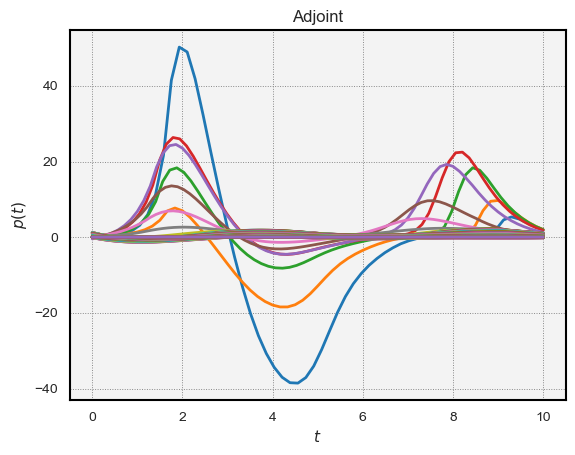

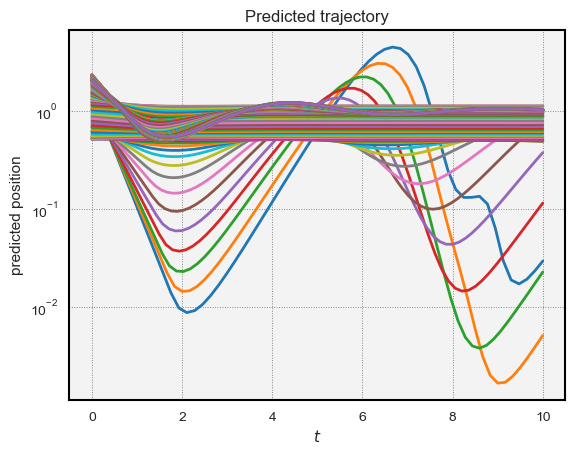

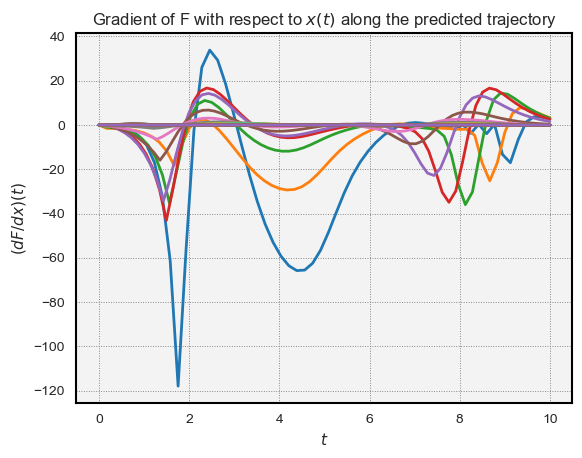

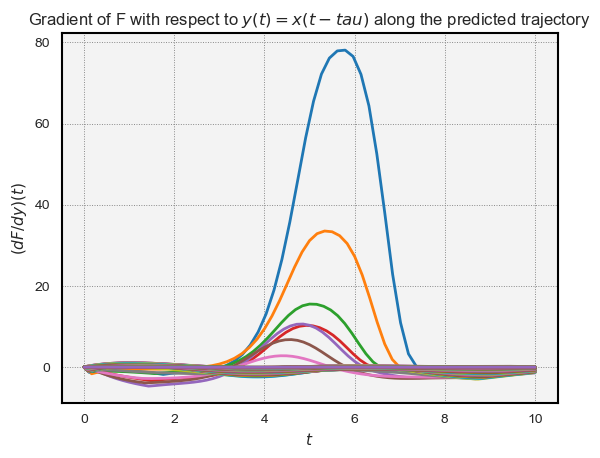

In [5]:
# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
MODEL       = Model(theta_0 = 1.75, theta_1 = 1.75);
DDE_Module  = NDDE_1D(MODEL);

# Pick a starting position, tau, and x_0
tau     = torch.tensor(1.75,     requires_grad = True);
x_0     = torch.clone(x_0_Target - 0.5).requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = list(MODEL.parameters()) + [tau, x_0];
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs, 
                                            eta_min     = Learning_Rate/10.);

# Train!
History_Dict, t_Predict, x_Predict  = Train( 
                                        DDE_Module          = DDE_Module, 
                                        x_0                 = x_0, 
                                        tau                 = tau, 
                                        T                   = T, 
                                        N_Epochs            = N_Epochs, 
                                        x_Target            = x_Target, 
                                        t_Target            = t_Target, 
                                        l                   = l,
                                        G                   = G,
                                        Loss_Threshold      = Loss_Threshold, 
                                        Optimizer           = Optimizer, 
                                        Scheduler           = Scheduler);

### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

In [4]:
####################################################################################################
# Lost loss history

plt.figure(0);
plt.plot(History_Dict["Loss"].detach().numpy());
seaborn.despine();
plt.xlabel("Epoch number");
plt.ylabel("Loss");
plt.yscale("log");
plt.title("Loss history");



####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_Target[0].detach().numpy(),      label = "true");
plt.plot(t_Predict, x_Target[0].detach().numpy(),   label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G = Model(theta_0 = 1.0, theta_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 1000;
grid_tau = torch.linspace(0.1, 3.6, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Target.detach().numpy(), x_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Loss_Fn(Predictions_i, Targets_i, t_Values);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");

NameError: name 'plt' is not defined